In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# must have gradientlab installed locally - see README

In [43]:
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer
from gradientlab.data_utils.experiment_path import get_ckpt_path_by_exp_name
from gradientlab.experiments.exp20251025_0_vlm_20m_in1k.torch_dataset import VLMCollate
import matplotlib.pyplot as plt

In [3]:
exp_name = Path(".").resolve().absolute().name
ckpt_path = get_ckpt_path_by_exp_name(exp_name)
exp_name

'exp20251025_0_vlm_20m_in1k'

In [14]:
model = AutoModelForCausalLM.from_pretrained(ckpt_path, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(ckpt_path)
device = "cuda"

model.eval().to(device)
collate_fn = VLMCollate(tokenizer)

In [10]:
model.cfg

ModelConfig {
  "architectures": [
    "GPTVForCausalLM"
  ],
  "attn_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "configuration_custom.ModelConfig",
    "AutoModelForCausalLM": "modeling_custom.GPTVForCausalLM"
  },
  "bos_token_id": 259,
  "dropout": 0.01,
  "dtype": "float32",
  "embed_dim": 256,
  "eos_token_id": 260,
  "ffn_mult": 4.0,
  "hidden_dim": 256,
  "hidden_squeeze_ratio": 0.5,
  "max_length": 4096,
  "model_type": "custom-gpt",
  "num_heads": 4,
  "num_hidden_layers": 22,
  "num_kv_groups": 2,
  "num_layers": 22,
  "pad_token_id": 0,
  "patch_size": 8,
  "tie_word_embeddings": false,
  "transformers_version": "4.57.1",
  "use_bias": true,
  "vocab_size": 512
}

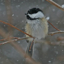

In [38]:
from gradientlab.img_utils.img_loader import ImageLoader

img_size = 64
img_orig = ImageLoader.to_pil("https://datasets-server.huggingface.co/cached-assets/visual-layer/imagenet-1k-vl-enriched/--/ac6afcdeb3be31c5ff6a7ff579874b3d372b7074/--/default/validation/4/image/image.jpg?Expires=1761923229&Signature=SdRtnbBLYhZT8pIDQmSlXKBLrpR7wDdOQJNH1ooo1JYHH8Ka-mQTHTTDpNArnK8aVzwKjFjfRt9V~EipzyDwaMPevzhmqol6lQ~DrkqOtJO7bxKt4g~pie~bludL3ZaHHU167~8dapztSB9h-won5ryPvdBLXwqEgX3hAmZpIJjEJGGB4QRWumT3l~lXgvm4sdECulacYLnVLD1ZuT7PL36Ew8vyK2TW03sTB0U67Jp41WvTw~MeaQ6cpWHr~zpwNGUZhIdJKQeyC-Er-aLisSfSjabO0O-pKGrpy0s1UJj~dP3zxucQKn5yNqIYBuZ30bLgLSzoE3beLDuyZuLHYg__&Key-Pair-Id=K3EI6M078Z3AC3")
img = ImageLoader.to_tensor(
    img_orig, img_size
)
img_orig.resize((img_size, img_size))

In [39]:
inputs = collate_fn([(img, "<|im_start|>")])
inputs = {k: v.to(device) for k,v in inputs.items()}

In [40]:
ids = model.generate(**inputs, do_sample=False, max_length=200)
tokenizer.decode(ids[0])

'<|im_start|> chickadee <|im_end|>'

In [58]:
import torch
from math import ceil

@torch.no_grad()
def plot_vlm_predictions_grid(model, tokenizer, imgs: list, batch_size=8, img_size=64, device="cuda"):
    all_preds = []
    model.eval()

    # Batch processing
    for i in range(0, len(imgs), batch_size):
        batch_imgs = imgs[i:i + batch_size]

        batch_data = []
        orig_imgs = []
        for src in batch_imgs:
            img_orig = ImageLoader.to_pil(src)
            img = ImageLoader.to_tensor(img_orig, img_size)
            batch_data.append((img, "<|im_start|>"))
            orig_imgs.append(img_orig)

        inputs = collate_fn(batch_data)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        ids = model.generate(**inputs, do_sample=False, max_length=200)
        preds = [tokenizer.decode(x, skip_special_tokens=True) for x in ids]
        all_preds.extend(zip(orig_imgs, preds))

    # Plotting grid
    n = len(all_preds)
    cols = min(4, n)
    rows = ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    axes = axes.flatten()

    for ax, (img, pred) in zip(axes, all_preds):
        ax.imshow(img.resize((img_size, img_size)))
        ax.set_title(pred, fontsize=10)
        ax.axis("off")

    for ax in axes[len(all_preds):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


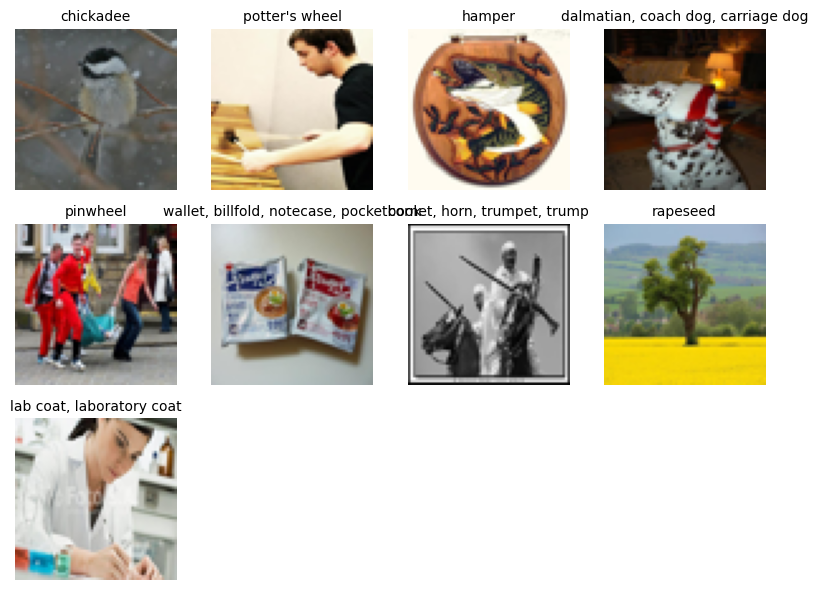

In [59]:
plot_vlm_predictions_grid(
    model,
    tokenizer,
    [
        "https://datasets-server.huggingface.co/cached-assets/visual-layer/imagenet-1k-vl-enriched/--/ac6afcdeb3be31c5ff6a7ff579874b3d372b7074/--/default/validation/4/image/image.jpg?Expires=1761923229&Signature=SdRtnbBLYhZT8pIDQmSlXKBLrpR7wDdOQJNH1ooo1JYHH8Ka-mQTHTTDpNArnK8aVzwKjFjfRt9V~EipzyDwaMPevzhmqol6lQ~DrkqOtJO7bxKt4g~pie~bludL3ZaHHU167~8dapztSB9h-won5ryPvdBLXwqEgX3hAmZpIJjEJGGB4QRWumT3l~lXgvm4sdECulacYLnVLD1ZuT7PL36Ew8vyK2TW03sTB0U67Jp41WvTw~MeaQ6cpWHr~zpwNGUZhIdJKQeyC-Er-aLisSfSjabO0O-pKGrpy0s1UJj~dP3zxucQKn5yNqIYBuZ30bLgLSzoE3beLDuyZuLHYg__&Key-Pair-Id=K3EI6M078Z3AC3",
        "https://datasets-server.huggingface.co/cached-assets/visual-layer/imagenet-1k-vl-enriched/--/ac6afcdeb3be31c5ff6a7ff579874b3d372b7074/--/default/validation/20/image/image.jpg?Expires=1761923229&Signature=REAogm0W-~z3583GTkqYbxImeH2FLaTE8vwxREvowWaoDUzzJTJ2MnjRWkx2YBseqvQ9Zc7Sm-CSWaksd8iRsBm7a7R2cH-XPsTBdCGMTOFOPqXzHht~67bqB6hRKYxRCDMsAay~jAZfry2y5n8B1Pe6gwvlS67CVidQHOHwWqJpISYlZkZ~Pw5WMBoXKk3lKvbgSIlo1yWNnV~-o01uD7pnSNBPNq3V8LmF-MffvFYqRaqLHkOJfUeguL7562U4Yf2juau6AdP3qDWop-E9H6BNBdumopQn9hhiaeOCVowYLkR4v4Zeq-Ev~mrwMt0-UQLdGLXqiCPaGQORUD-EVw__&Key-Pair-Id=K3EI6M078Z3AC3",
        "https://datasets-server.huggingface.co/cached-assets/visual-layer/imagenet-1k-vl-enriched/--/ac6afcdeb3be31c5ff6a7ff579874b3d372b7074/--/default/validation/315/image/image.jpg?Expires=1761923911&Signature=ZMrc0EqvqYIcoxUElinpzzlX0INVxDEFxZfWPfYlNAQcmRhjgwoVUzDD0ydnc7HKqvvU-3E7cNuRdJnenvJvrfZceNGjMPf8kk7lmh5Uy5a4L1p6ZfNpYtkvU7zFhVV9xdRm7V9WXbE6WVhIUyx~7600m5-zguUPNygZq6X9UcX23mpjEMAQYQL8Tewh0xhCOhqUPP1nWtVAk5gI4To5NA~MR0S6avZW3ch4pXJdJqCJIaF2~ZANGkq185grmGEeYTACpUuMQ2DZxxyWpiZggLR~RkBCza~J2jLc9aCA1KdQVIFjCF3iZmhCnaUXSn0Mf0R0Y7~VNv-PBHi2DLuouw__&Key-Pair-Id=K3EI6M078Z3AC3",
        "https://datasets-server.huggingface.co/cached-assets/visual-layer/imagenet-1k-vl-enriched/--/ac6afcdeb3be31c5ff6a7ff579874b3d372b7074/--/default/validation/36/image/image.jpg?Expires=1761923229&Signature=dFgWunpih6I9opHUJK3-wnUPQdHRIlayA2Wkl537grN4IHjqKMm~wNIBmU7x07~eu~4Weq-gkFTfOUiR4zUA2U71xSBFQwuT8opQJQzMsqlUjcqWWQgUd9ORNeQobWS8Glkw1NDEXVOMkvjFFJkh8Mu54IiVF4DlTWBXALdXMQm2TrsjdF4vvyWiWivFaEmC3w1ZRcvnA1U~FnFCQyqqPPcbAPseRxWtzOiN4kDNlYzBxvzsF-itWPNjWxpXzBYGmdRd8aBHFONMpfsLYca3yzcAyCdImkwH-EBwPFeb6S2TUuwEOBUbt4b8E6mKk35Qwj-HAzEFQtpVwmA9CF0TlA__&Key-Pair-Id=K3EI6M078Z3AC3",
        "https://datasets-server.huggingface.co/cached-assets/visual-layer/imagenet-1k-vl-enriched/--/ac6afcdeb3be31c5ff6a7ff579874b3d372b7074/--/default/validation/49/image/image.jpg?Expires=1761923229&Signature=qhGm1sfq~iFRBgUivvhFXJf9t~cjfy2ejmHj6HwbVItSlV8Rkqo-59jJKw8-Gwi2Z1T1BZtjr3iDyNMeetMH9SyjcCHjeDF7dnn7lg~qfFQmP4z8acoCacYx461Yx29ordXuLbEhlkqmp6IIZvpK~rf1-GV7XYmqMd9erqJmlOg0vw8U~dPmgr1tder~SN-a0VRr6Qq9KZBnfSA1xu8P4qU5eqqtwUuS9y2gn~m0loj4NesSuJ-ZW6r-SkcC4tfv4a4BRx6AdXpItC8-jpn4iwzdjHVae2-KdyIalAnGLkEV~Zap3U-39wqOty82co4qpZUtJkTE0rjZdQEgdtlbaA__&Key-Pair-Id=K3EI6M078Z3AC3",
        "https://datasets-server.huggingface.co/cached-assets/visual-layer/imagenet-1k-vl-enriched/--/ac6afcdeb3be31c5ff6a7ff579874b3d372b7074/--/default/validation/76/image/image.jpg?Expires=1761923229&Signature=LxWGHMfQ4A1v3L98To8LPJYGzJnSS856DUHGjXe0rS9gVw9VMYaMTHp99a5Ectk2SNLh83~PHug9uQh94TUEn86mX2h-AxnFSbq88We2o8l4tCPh219mLD8yesmd8bDRvFekgkcd2oXKWEu-E59Mn9UBiuw2gLipWAqdy6AAb-mwrzUVNnaY6vOub7IKV-zP~bxkuLhY5MyrDcKYFar6Oky865QWm8bxWxri9WNb8L5iBlrGUBGa~tyLDCGyi8ctFvPW2GExBRbXkOpv1B8QK2hAhBuvCyGs6nHbTTlL3dSez8gH3HClv7x1XWfkaoL~B8QHgXjT3W0vcha18~jgpg__&Key-Pair-Id=K3EI6M078Z3AC3",
        "https://datasets-server.huggingface.co/cached-assets/visual-layer/imagenet-1k-vl-enriched/--/ac6afcdeb3be31c5ff6a7ff579874b3d372b7074/--/default/validation/96/image/image.jpg?Expires=1761923229&Signature=OsEDY6E8JYYWppk~skZpS2w771mw4m9l~NtdcSBXRK95Lgd~~czC5OV813JbYhIvzN42gAl6yX63yFPapiD0PpmyYMFAudMXt~srGgzxTc-Te-YGKtgR7J~5sjHRgZq7hc15Lm9hX6vV6h38f4VPtwY5NaOcsTCl~a4ZnZynsQ7TJKay0I5TB7X-qmbsCAExb3DiepcvoPIW6ilTheWxNAvdzWK~z6dsEodCpOCPYBcrAJKTpR20NgG8X~r8iYLv4zchycqWKUWmoF~fNvRlfmX3HZmrEtodiVgxvnU8L6lKBCH17BoOFMtdj0cQbHjpVAPZyFblcsO5sWniiPB5kQ__&Key-Pair-Id=K3EI6M078Z3AC3",
        "https://datasets-server.huggingface.co/cached-assets/visual-layer/imagenet-1k-vl-enriched/--/ac6afcdeb3be31c5ff6a7ff579874b3d372b7074/--/default/validation/204/image/image.jpg?Expires=1761923871&Signature=Y~t6rArOSoEYfo8q080nqTsniIIUYvt3znYqxIyrTfYKMfIhTl5GhOJ66KQnIE~UnlsBR8JLrZxrAbniXECxGuoFUVLfPH9VAHgTtbhkRfD8d4BYYGpe9U0Zx8QmnNIMiIFfzurXKGr5gqfxDnHoqXbr5jEWnd7QnEiZtO-aEqlaI42l2j-uLeXQorcnsNkrh~kBUDBZxQdUkEobtTAB4eiSFGrGYXcQDSpJ7eCgxoMqRcwOpovzCcIj5P9USonGkEhpAGkR02DAKHMG2LDGmYPCZWQTKu-Mxww5uYDjdgeADBj-mJ8ThWwG7~Ei7-hFTxLxmXixagONpa-5Qf2L2A__&Key-Pair-Id=K3EI6M078Z3AC3",
        "https://datasets-server.huggingface.co/cached-assets/visual-layer/imagenet-1k-vl-enriched/--/ac6afcdeb3be31c5ff6a7ff579874b3d372b7074/--/default/validation/340/image/image.jpg?Expires=1761923911&Signature=IpBFqZn4juJ2o8hRnIosY8KBa8DRMJAFZQpg3Mvk57r~yw4N3Z9qbsiNOiwo6XHUNMfI8b2s96LEkh67wRTsbxG2Gs0EWlD41Wxi4AXpjV8MJEIREFN5QTuzynrzeEmKE13ov8RzE8MtLf2c1WK22RVPy5nTJN1q2U4CRGscconRGMkjef0nV1xb6byHcMP84NfPeiwTzwW0q1dVP4wSX4UUthtuGydSP1tPulmqD2SFYMLYGzJ62rqQepAk2rLYx7JZ82D6nSSW3PlUfktR19vJhMBXOdIsa7s3N7hXKbdtMyl3PrR2V6o3Ifejmareef8kK6M-MqHHtzEmDIMXVg__&Key-Pair-Id=K3EI6M078Z3AC3"
    ],
    batch_size=8,
    img_size=64,
    device="cuda",
)